# Ground temperature history inversion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend
from heat import heat
import pickle
from tqdm import tqdm
import multiprocessing as mp

# Load the real data

In [2]:
filepath = '/data/fast1/jm-scratch/data_proc.pkl'

with open(filepath,'rb') as file:
    data = pickle.load(file)
real_data = data['ALHIC1902_23_5min']

z_full = np.array(real_data[0])
z_real = z_full[::10]
T_full = np.array(real_data[2])
T_real = T_full[::10]

max_depth = max(z_real)
nz = len(z_real)
print(f'max_depth={max_depth}')
print(f'nz={nz}')
# T = real_data[1].values
# T.shape

max_depth=205.93200000000002
nz=82


/home/bpl7/.conda/envs/python3.11-obspy/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))
/home/bpl7/.conda/envs/python3.11-obspy/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


# Generate the data kernel matrix, G
Note that we solve for the perturbation that deviates for a steady state solution with constant surface temperature and constant basal heat flux.  

In [17]:
# Define a steady state model
tsurf_avg=-32.1
dTdz = 0.02

def steadystate(z):
    return tsurf_avg+dTdz*z

data_minus_stead_state = T_real #- steadystate(z_real)

In [18]:
# Function to organize the Greens Function
def get_G(i):
    
    delta = tsurf_avg*np.ones(number_of_time_steps)
    delta[i] =  1

    U,t,z = heat(delta,tmax=end_year,tmin=start_year,nt=number_of_time_steps,zmax=max_depth,
            dTdz=dTdz,nz=(nz-1))
    return U[:,-1]

# Run 1: 100 year time scale

In [35]:
start_year = 1923
end_year = 2023
number_of_time_steps = 399
t = np.linspace(start_year,end_year, number_of_time_steps+1)

G = np.zeros((nz,number_of_time_steps))
for i in tqdm(range(number_of_time_steps)): 
    G[:,i] = get_G(i) #- steadystate(z_real)
G = G[:,1:]

100%|██████████| 399/399 [02:29<00:00,  2.67it/s]


(205.93200000000002, 0.03100000000000591)

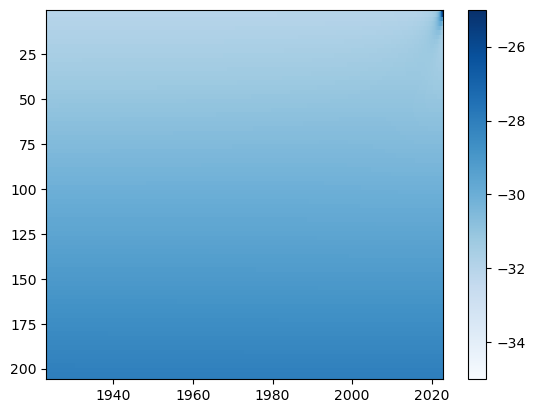

In [36]:
c=plt.pcolormesh(t[1:-1],z_real,G,vmin=-35,vmax=-25,cmap='Blues')
plt.colorbar(c)
plt.ylim([z_real[-1],z_real[0]])

# Inversion with Real Data

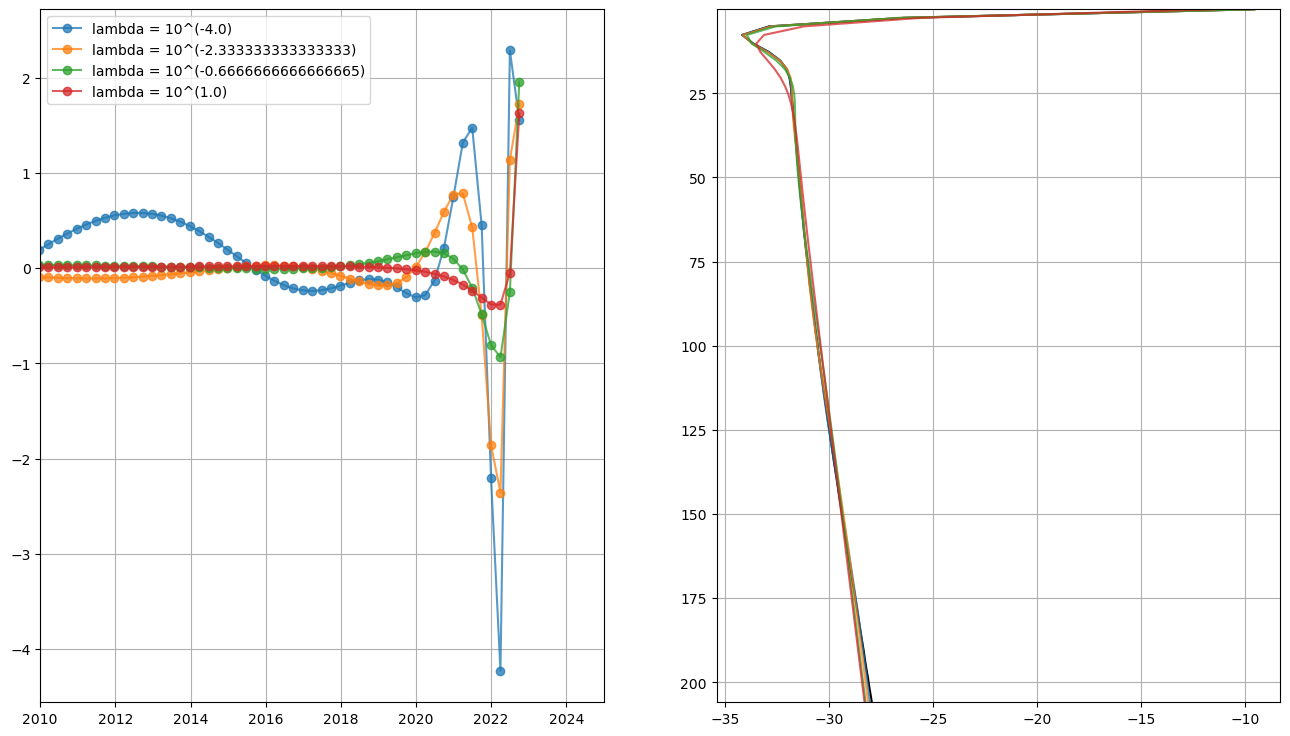

In [37]:
fig,ax=plt.subplots(1,2,figsize=(16,9))
ax[1].plot(data_minus_stead_state,z_real,'-k')
for lmbda in np.logspace(-4,1,4): # Damping parameter (regularization parameter)

    # Formulate the regularized least squares problem
    # We need to augment A with the regularization term
    A_augmented = np.vstack([G, np.sqrt(lmbda) * np.eye(G.shape[1])])
    b_augmented = np.concatenate([data_minus_stead_state, np.zeros(G.shape[1])])

    # Solve the regularized least squares problem
    x_damped, residuals, rank, singular_values = np.linalg.lstsq(A_augmented, b_augmented, rcond=None)
    ax[0].plot(t[1:-1],x_damped,'-o',
               label=f'lambda = 10^({np.log10(lmbda)})',alpha=0.75)

    T_fit = np.matmul(G,x_damped)
    ax[1].plot(T_fit,z_real,alpha=0.75)


ax[1].set_ylim([z_real[-1],z_real[0]])
# ax[1].set_xlim([-2.5,2.5])
ax[0].grid()
ax[1].grid()
ax[0].set_xlim([2010,2025])
ax[0].legend()

# plt.plot(t[1:-1],synthetic_history,'--k')

# Run 2: 1000 year timescale

In [8]:
start_year = 1023
end_year = 2023
number_of_time_steps = 199
t = np.linspace(start_year,end_year, number_of_time_steps+1)

G = np.zeros((nz,number_of_time_steps))
for i in tqdm(range(number_of_time_steps)): 
    G[:,i] = get_G(i) - steadystate(z_real)
G = G[:,1:]

100%|██████████| 199/199 [00:37<00:00,  5.37it/s]


(205.93200000000002, 0.03100000000000591)

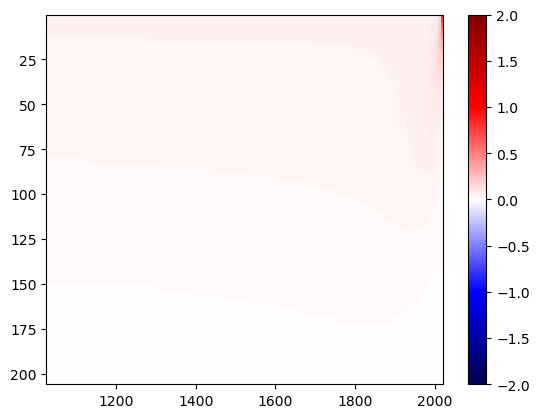

In [9]:
vm=2
c=plt.pcolormesh(t[1:-1],z_real,G,vmin=-vm,vmax=vm,cmap='seismic')
plt.colorbar(c)
plt.ylim([z_real[-1],z_real[0]])

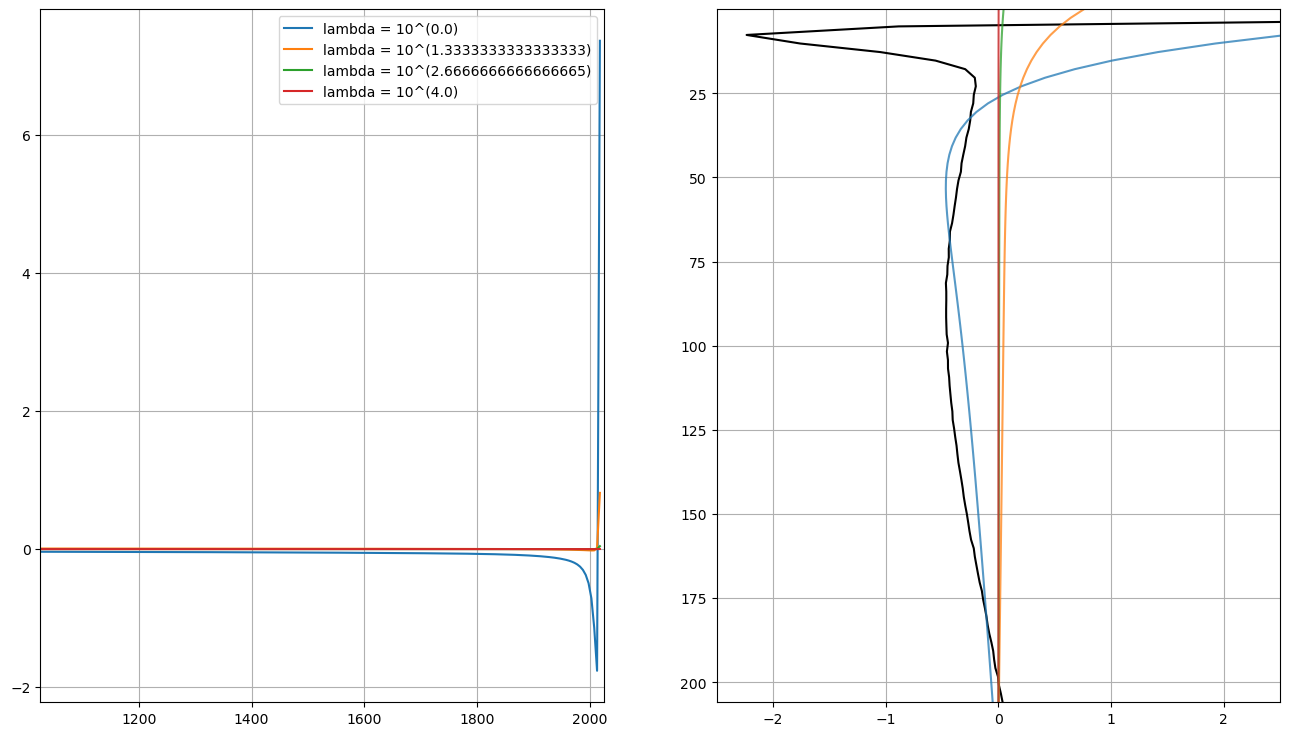

In [10]:
fig,ax=plt.subplots(1,2,figsize=(16,9))
ax[1].plot(data_minus_stead_state,z_real,'-k')
for lmbda in np.logspace(0,4,4): # Damping parameter (regularization parameter)

    # Formulate the regularized least squares problem
    # We need to augment A with the regularization term
    A_augmented = np.vstack([G, np.sqrt(lmbda) * np.eye(G.shape[1])])
    b_augmented = np.concatenate([data_minus_stead_state, np.zeros(G.shape[1])])

    # Solve the regularized least squares problem
    x_damped, residuals, rank, singular_values = np.linalg.lstsq(A_augmented, b_augmented, rcond=None)
    ax[0].plot(t[1:-1],x_damped,label=f'lambda = 10^({np.log10(lmbda)})')

    T_fit = np.matmul(G,x_damped)
    ax[1].plot(T_fit,z_real,alpha=0.75)


ax[1].set_ylim([z_real[-1],z_real[0]])
ax[1].set_xlim([-2.5,2.5])
ax[0].grid()
ax[1].grid()
ax[0].set_xlim([1025,2025])
ax[0].legend()

# plt.plot(t[1:-1],synthetic_history,'--k')

In [11]:
# Run 3: 10 year time scale
start_year = 2003
end_year = 2023
number_of_time_steps = 199
t = np.linspace(start_year,end_year, number_of_time_steps+1)

G = np.zeros((nz,number_of_time_steps))
for i in tqdm(range(number_of_time_steps)): 
    G[:,i] = get_G(i) - steadystate(z_real)
G = G[:,1:]

100%|██████████| 199/199 [00:37<00:00,  5.37it/s]


(205.93200000000002, 0.03100000000000591)

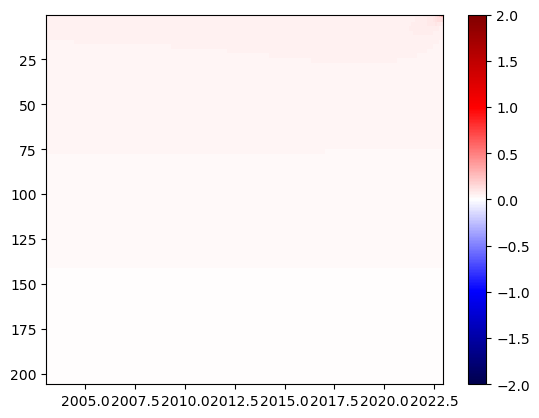

In [12]:
vm=2
c=plt.pcolormesh(t[1:-1],z_real,G,vmin=-vm,vmax=vm,cmap='seismic')
plt.colorbar(c)
plt.ylim([z_real[-1],z_real[0]])

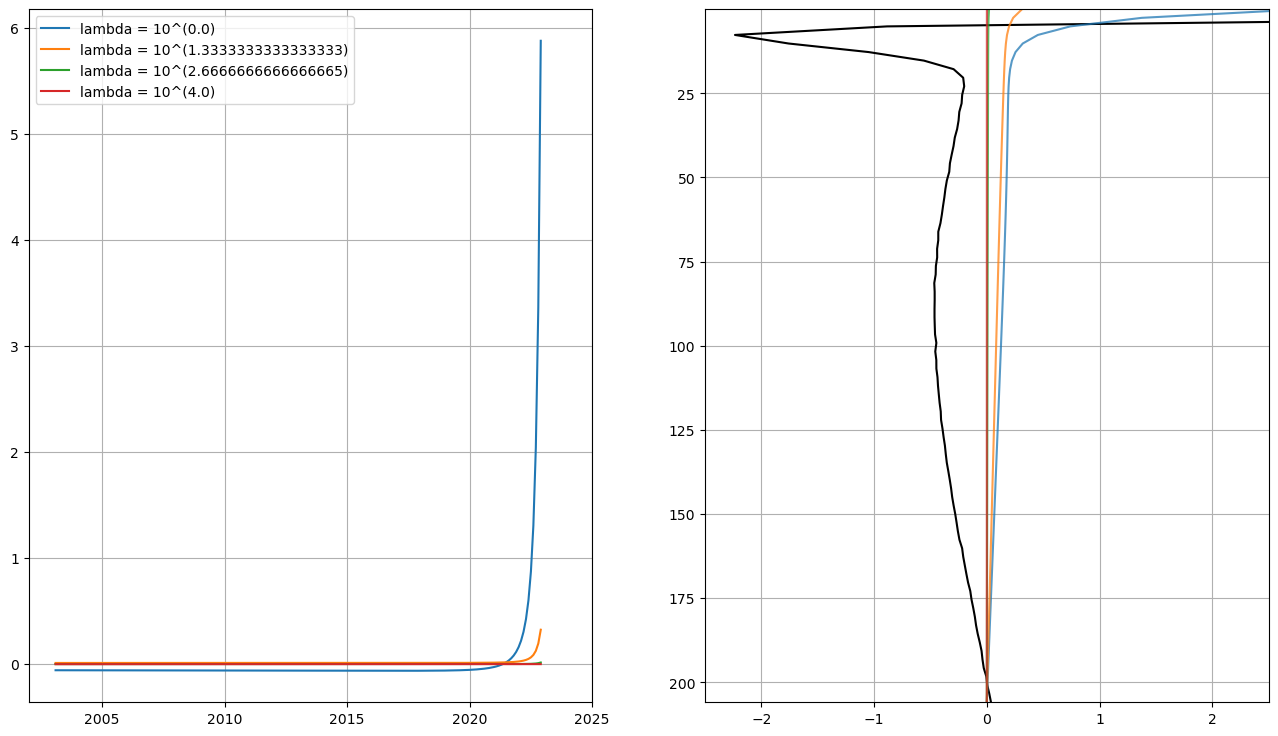

In [13]:
fig,ax=plt.subplots(1,2,figsize=(16,9))
ax[1].plot(data_minus_stead_state,z_real,'-k')
for lmbda in np.logspace(0,4,4): # Damping parameter (regularization parameter)

    # Formulate the regularized least squares problem
    # We need to augment A with the regularization term
    A_augmented = np.vstack([G, np.sqrt(lmbda) * np.eye(G.shape[1])])
    b_augmented = np.concatenate([data_minus_stead_state, np.zeros(G.shape[1])])

    # Solve the regularized least squares problem
    x_damped, residuals, rank, singular_values = np.linalg.lstsq(A_augmented, b_augmented, rcond=None)
    ax[0].plot(t[1:-1],x_damped,label=f'lambda = 10^({np.log10(lmbda)})')

    T_fit = np.matmul(G,x_damped)
    ax[1].plot(T_fit,z_real,alpha=0.75)


ax[1].set_ylim([z_real[-1],z_real[0]])
ax[1].set_xlim([-2.5,2.5])
ax[0].grid()
ax[1].grid()
ax[0].set_xlim([2002,2025])
ax[0].legend()

# plt.plot(t[1:-1],synthetic_history,'--k')